In [2]:
setwd('/import/DB/zhang//data')

In [3]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [4]:
daa = readRDS('./scRNA.rename.rds')

In [5]:
DefaultAssay(daa) = 'RNA'

In [6]:
library(Seurat)

In [7]:
Idents(daa) = 'celltype'

In [ ]:
DimPlot(daa, group.by="celltype", label=T, label.size=5, reduction='umap')

In [ ]:
OS = subset(daa,celltype =='Neutrophils')

In [ ]:
DimPlot(OS)

In [ ]:
immune.combined = OS

library(harmony)

DefaultAssay(immune.combined) = 'RNA'

table(OS$orig.ident)

sceList <- SplitObject(immune.combined, split.by = "orig.ident")

single.ob=merge(sceList[[1]],sceList[2:length(sceList)])

DefaultAssay(single.ob) = 'RNA'

scRNA_harmony = single.ob

scRNA_harmony <- NormalizeData(scRNA_harmony) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose=FALSE)
##整合
system.time({scRNA_harmony <- RunHarmony(scRNA_harmony, group.by.vars = "orig.ident")})

scRNA_harmony <- RunUMAP(scRNA_harmony, reduction = "harmony", dims = 1:30)

scRNA_harmony <- FindNeighbors(scRNA_harmony, reduction = "harmony", dims = 1:30) %>% FindClusters(resolution =  0.1)
##作图
#group_by_cluster

In [ ]:
options(repr.plot.width = 12,repr.plot.height = 8)

In [ ]:
table(scRNA_harmony$group)

In [ ]:
options(repr.plot.width = 8,repr.plot.height = 6)

In [ ]:
DimPlot(scRNA_harmony, reduction = "umap", split.by = "group",ncol = 2,label = T)

In [ ]:
DimPlot(scRNA_harmony, reduction = "umap", label=T) 

In [ ]:
DefaultAssay(scRNA_harmony) = 'RNA'

In [ ]:
DotPlot(scRNA_harmony,features = 'CD14')

In [ ]:
FeaturePlot(scRNA_harmony,features = 'TBC1D16',split.by = 'group')

In [ ]:
Idents(scRNA_harmony) ='seurat_clusters'

In [ ]:
SCE = subset(scRNA_harmony,idents = c(0,1,2))

In [ ]:
Idents(SCE) = 'seurat_clusters'
DefaultAssay(SCE) = 'RNA'
sce.markers <- FindAllMarkers(object = SCE, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

In [ ]:
write.csv(sce.markers,file = 'neu.sce.markers.csv')

In [ ]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

In [ ]:
library(ggplot2)

In [ ]:
options(repr.plot.height = 7,repr.plot.width = 6)

 DotPlot(SCE, features = unique(top5$gene) ,
 assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [ ]:
saveRDS(SCE,file = 'neu.final.rds')

In [ ]:
DotPlot(SCE,features = 'ADPGK')

In [ ]:
scedata = SCE

In [ ]:
scedata$orig.ident = scedata$sample

In [ ]:
scedata$celltype = paste0('Neu',scedata$seurat_clusters)

In [ ]:
Idents(scedata) = 'celltype'

In [ ]:
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数

In [ ]:
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- data.frame(Cellratio)

In [ ]:
library(reshape2)
cellper <- dcast(Cellratio,Var2~Var1, value.var = "Freq")#长数据转为宽数据
rownames(cellper) <- cellper[,1]
cellper <- cellper[,-1]

In [ ]:
sample <- rownames(cellper)

In [ ]:
group <- c(rep('Con',8),rep('OS',4))


samples <- data.frame(sample, group)#创建数据框

In [ ]:


rownames(samples)=samples$sample
cellper$sample <- samples[rownames(cellper),'sample']#R添加列
cellper$group <- samples[rownames(cellper),'group']#R添加列

In [131]:


###作图展示
pplist = list()
sce_groups = unique(scedata$celltype)


In [132]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(cowplot)
for(group_ in sce_groups){
  cellper_  = cellper %>% select(one_of(c('sample','group',group_)))#选择一组数据
  colnames(cellper_) = c('sample','group','percent')#对选择数据列命名
  cellper_$percent = as.numeric(cellper_$percent)#数值型数据
  cellper_ <- cellper_ %>% group_by(group) %>% mutate(upper =  quantile(percent, 0.75), 
                                                      lower = quantile(percent, 0.25),
                                                      mean = mean(percent),
                                                      median = median(percent))#上下分位数
# print(group_)
print(cellper_$median)
      pp1 = ggplot(cellper_,aes(x=group,y=percent)) + #ggplot作图
    geom_jitter(shape = 21,aes(fill=group),width = 0.25) + 
    stat_summary(fun=mean, geom="point", color="grey60") +
    theme_cowplot() +
    theme(axis.text = element_text(size = 10),axis.title = element_text(size = 10),legend.text = element_text(size = 10),
          legend.title = element_text(size = 10),plot.title = element_text(size = 10,face = 'plain'),legend.position = 'none') + 
    labs(title = group_,y='Percentage') +
    geom_errorbar(aes(ymin = lower, ymax = upper),col = "grey60",width =  1)
  
  ###组间t检验分析
  labely = max(cellper_$percent)
  compare_means(percent ~ group,  data = cellper_)
  my_comparisons <- list( c("Con", "OS") )
  pp1 = pp1 + stat_compare_means(comparisons = my_comparisons,size = 3,method = "t.test")
  pplist[[group_]] = pp1
}
  

 [1] 0.4122635 0.4122635 0.4122635 0.4122635 0.4122635 0.4122635 0.4122635
 [8] 0.4122635 0.1510183 0.1510183 0.1510183 0.1510183
 [1] 0.3495282 0.3495282 0.3495282 0.3495282 0.3495282 0.3495282 0.3495282
 [8] 0.3495282 0.7469450 0.7469450 0.7469450 0.7469450
 [1] 0.24531782 0.24531782 0.24531782 0.24531782 0.24531782 0.24531782
 [7] 0.24531782 0.24531782 0.00203666 0.00203666 0.00203666 0.00203666


In [133]:
options(repr.plot.height = 8,repr.plot.width = 9)

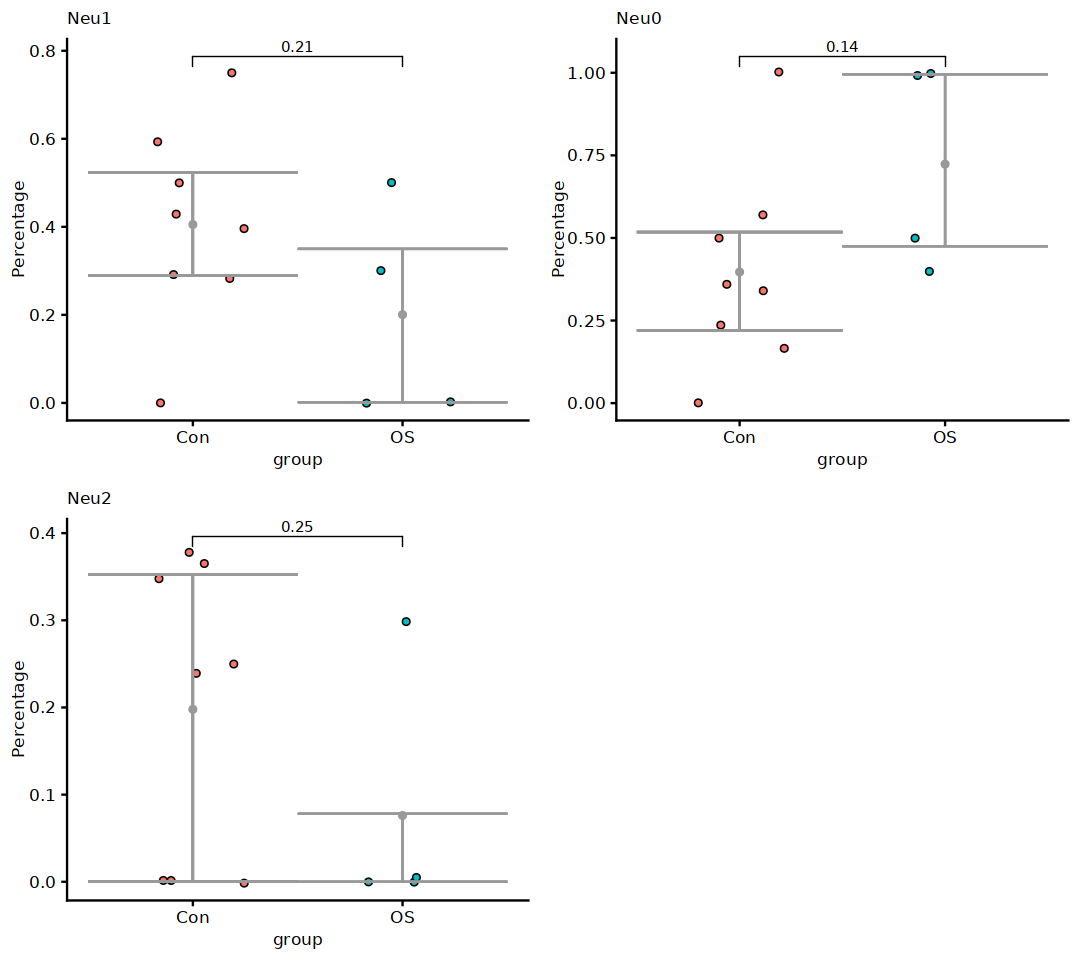

In [135]:
 library(cowplot)
plot_grid(pplist[[1]],
          pplist[[2]],
          pplist[[3]])


          C1           C2           C3           C4           S1           S2 
           4            4            7            1         1317         2789 
          S3           S4 WH2109002886 WH2112008442 WH2201006389 WH2203005877 
         881         1533            8           10            1          491 


    Neu1     Neu0     Neu2 
0.328981 0.345870 0.325149 

      
         OS control
  Neu1    8    2310
  Neu0  497    1940
  Neu2    5    2286

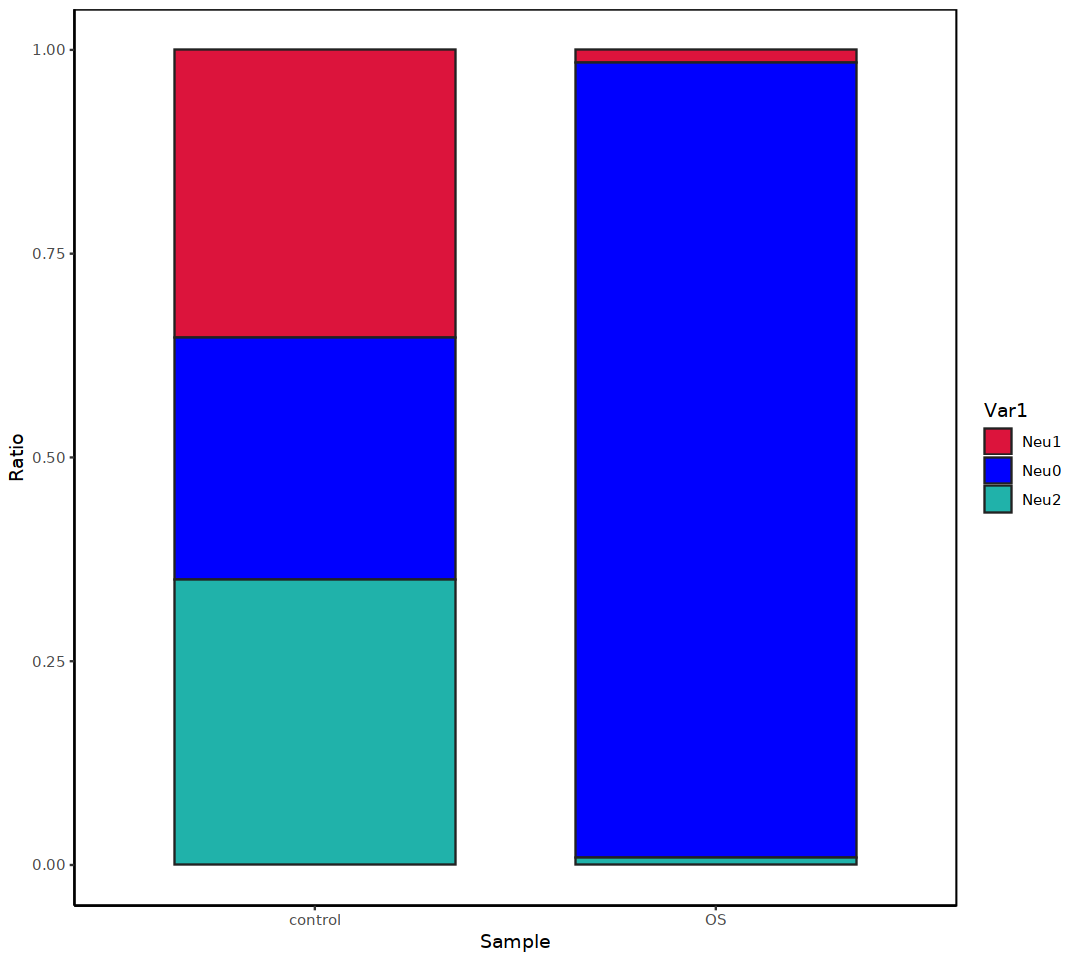

In [136]:
scRNA = scedata
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$group)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$group), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('control','OS'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

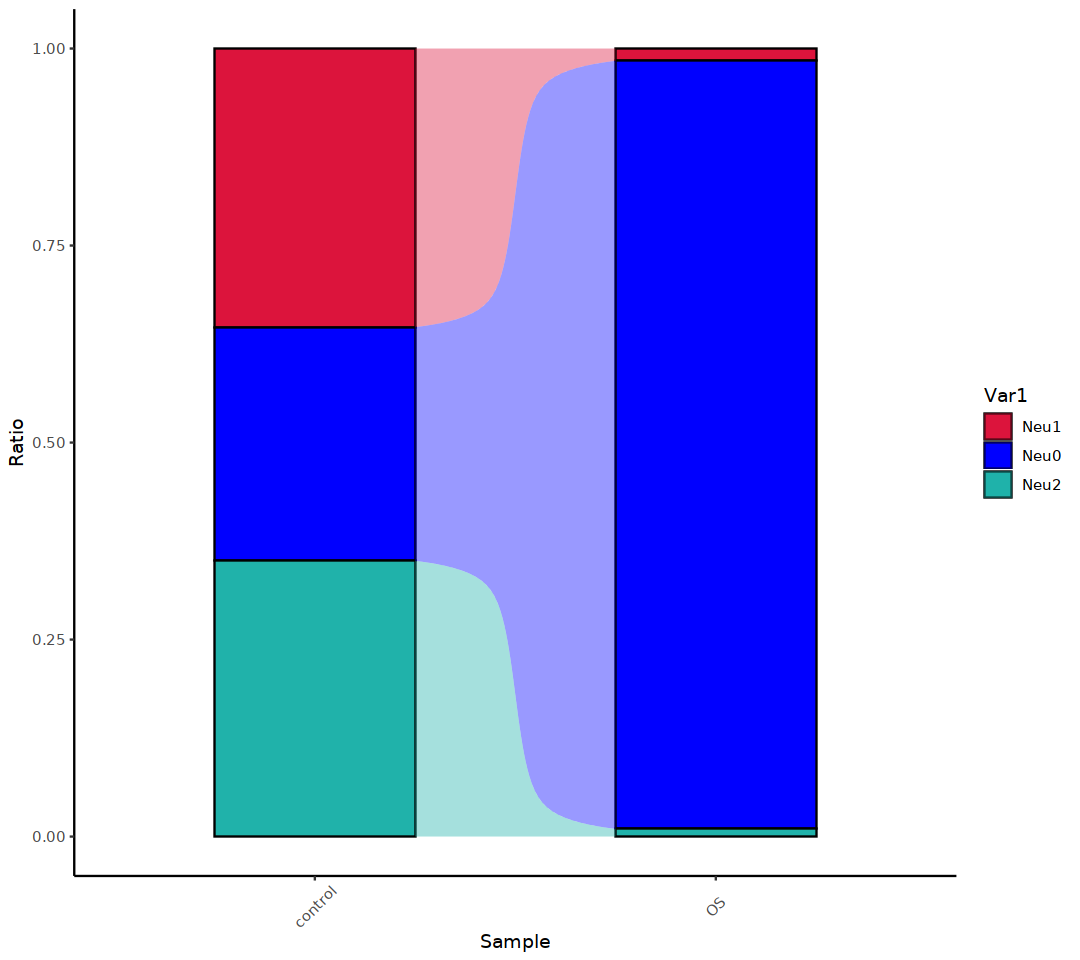

In [137]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [138]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

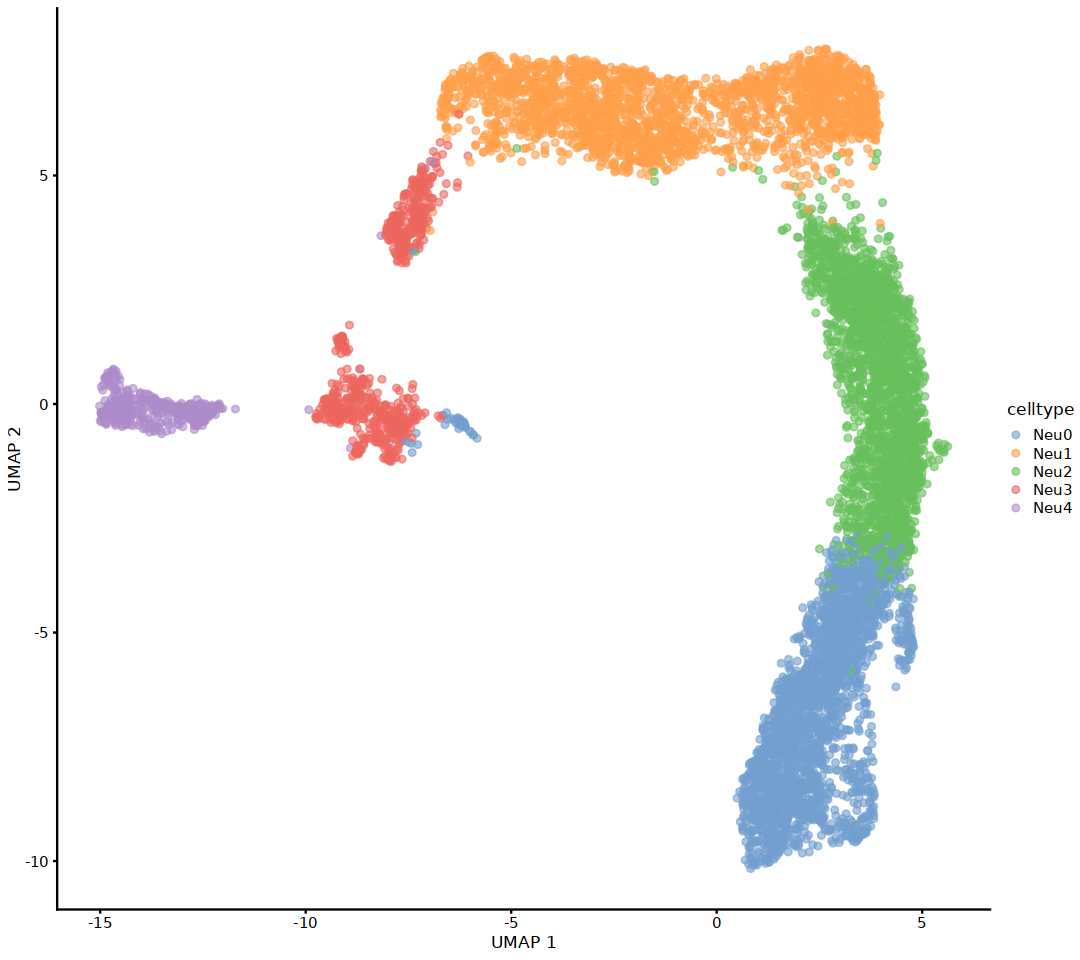

In [63]:
sce <- as.SingleCellExperiment(scedata)
 
#Visualize the data
plotReducedDim(sce, colour_by="celltype", dimred = "UMAP") 

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods

  [[ suppressing 13 column names 'C1', 'C2', 'C3' ... ]]



6 x 13 sparse Matrix of class "dgCMatrix"
                               
1 . . . . 33  1  4 10 . . . . .
2 . . . .  3 72  .  3 . . . . .
3 . . . . 20 10  5  9 . . . . .
4 . . . .  1 65  .  5 . . . . .
5 . . . .  4 17 10 31 . . . . .
6 . . . .  4  1 37 17 . . . . .

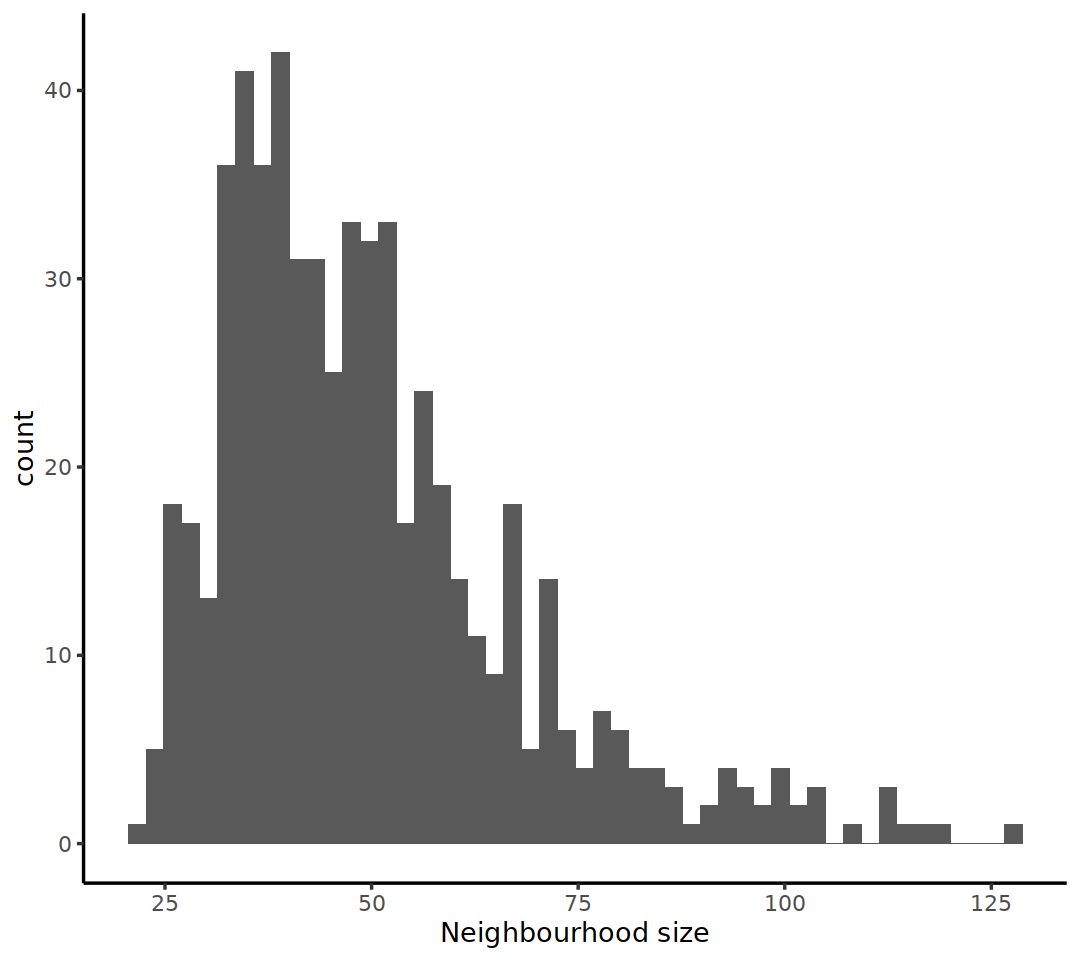

In [64]:
scmilo <- Milo(sce)
 
#Construct KNN graph
scmilo <- buildGraph(scmilo, k = 20, d = 20,reduced.dim = "PCA")
 
#Defining representative neighbourhoods on the KNN graph
set.seed(10)
scmilo <- makeNhoods(scmilo, prop = 0.1,
                     k = 20, d = 20, 
                     refined = TRUE, reduced_dims = "PCA")
plotNhoodSizeHist(scmilo)
 
#Counting cells in neighbourhoods
scmilo <- countCells(scmilo, 
                     meta.data = as.data.frame(colData(scmilo)), 
                     sample = "sample")
head(nhoodCounts(scmilo))

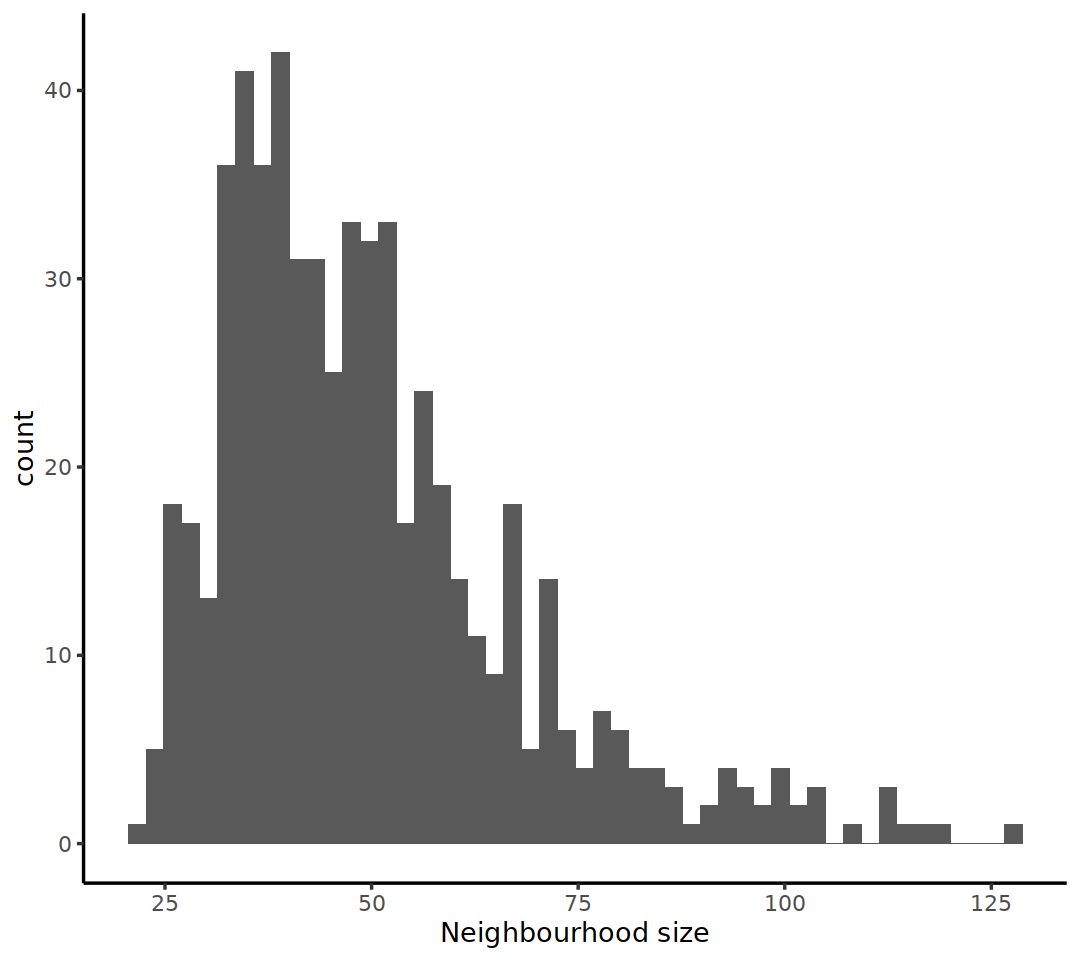

In [65]:
plotNhoodSizeHist(scmilo)

In [66]:
sc_design <- data.frame(colData(scmilo))[,c("sample", "group")]

In [67]:
sc_design <- distinct(sc_design)
rownames(sc_design) <- sc_design$sample

In [68]:
sc_design <- sc_design[colnames(nhoodCounts(scmilo)), , drop=FALSE]
table(sc_design$group)


     OS control 
      5       8 

In [69]:

#odDistance(scmilo, d = 20, reduced.dim = "PCA")

In [70]:
rownames(sc_design) <- sc_design$sample

In [71]:
sc_design$control = c(rep(1,4),rep(0,5),rep(1,4))
sc_design$OS = c(rep(0,4),rep(1,5),rep(0,4))

In [72]:
sc_design$control  = as.factor(sc_design$control )

In [73]:
sc_design$OS = as.factor(sc_design$OS )

In [74]:
model <- model.matrix(~ 0+group, data=sc_design)

In [75]:
model

,groupOS,groupcontrol
C1,0,1
C2,0,1
C3,0,1
C4,0,1
S1,0,1
S2,0,1
S3,0,1
S4,0,1
WH2109002886,1,0
WH2109013167,1,0


In [77]:
contrast.1 <- c("groupOS -  groupcontrol") # the syntax is <VariableName><ConditionLevel> - <VariableName><ControlLevel>

# we need to use the ~ 0 + Variable expression here so that we have all of the levels of our variable as separate columns in our model matrix
results <- testNhoods(scmilo, design = ~0 + group, design.df = sc_design, model.contrasts = contrast.1,
                         fdr.weighting="graph-overlap", norm.method="TMM")
table(results$SpatialFDR < 0.1)

Using TMM normalisation

Warning message in max(abs(logR)):
"no non-missing arguments to max; returning -Inf"
Performing spatial FDR correction withgraph-overlap weighting




FALSE  TRUE 
    9   579 

In [78]:
results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,-7.859274,13.99517,10.64028,0.001112246,0.002503072,3,0.002287355
4,-7.944837,14.07936,10.22027,0.001395737,0.002503072,4,0.002287355
5,-7.945544,14.07847,10.22471,0.001392391,0.002503072,5,0.002287355
7,-7.989863,14.12106,10.01563,0.001559372,0.002503072,7,0.002287355
10,-7.590801,13.75613,10.64392,0.001110061,0.002503072,10,0.002287355
11,-7.908528,14.04549,10.38632,0.001275818,0.002503072,11,0.002287355


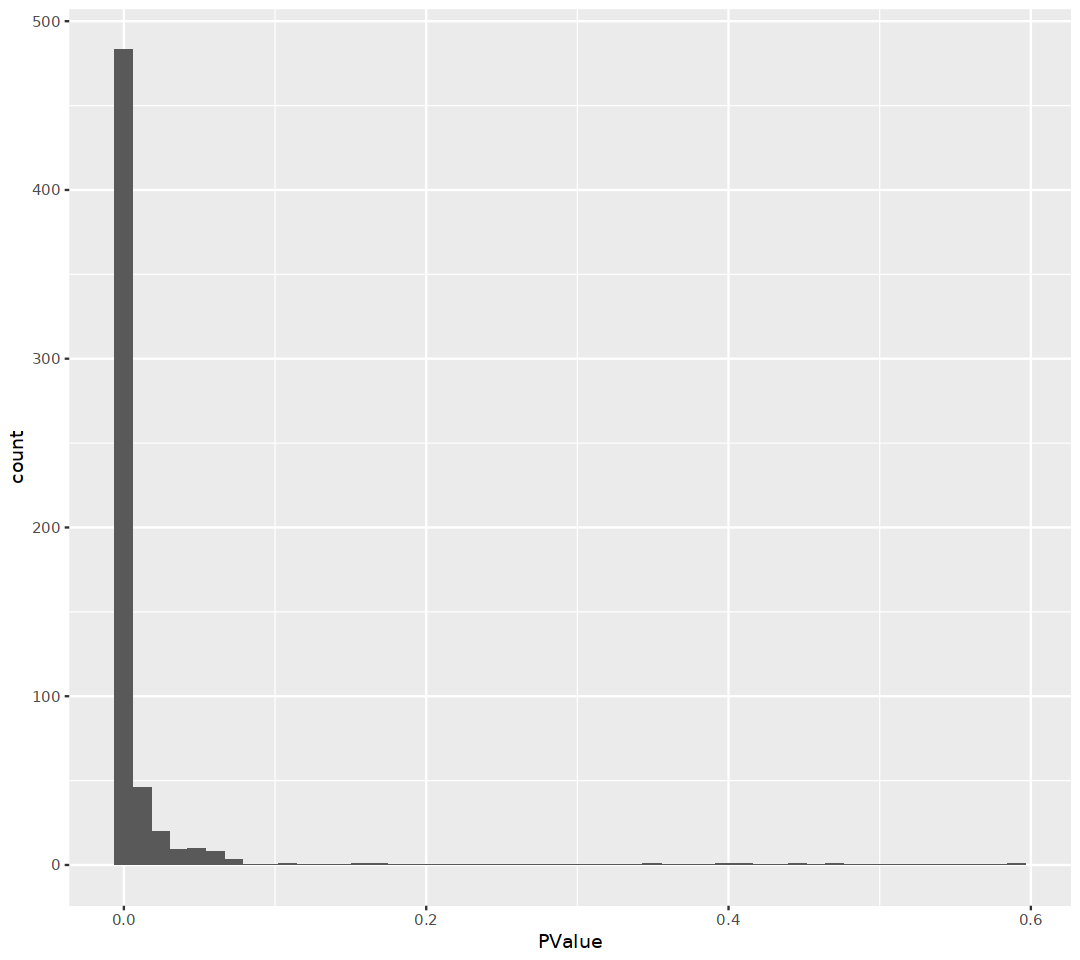

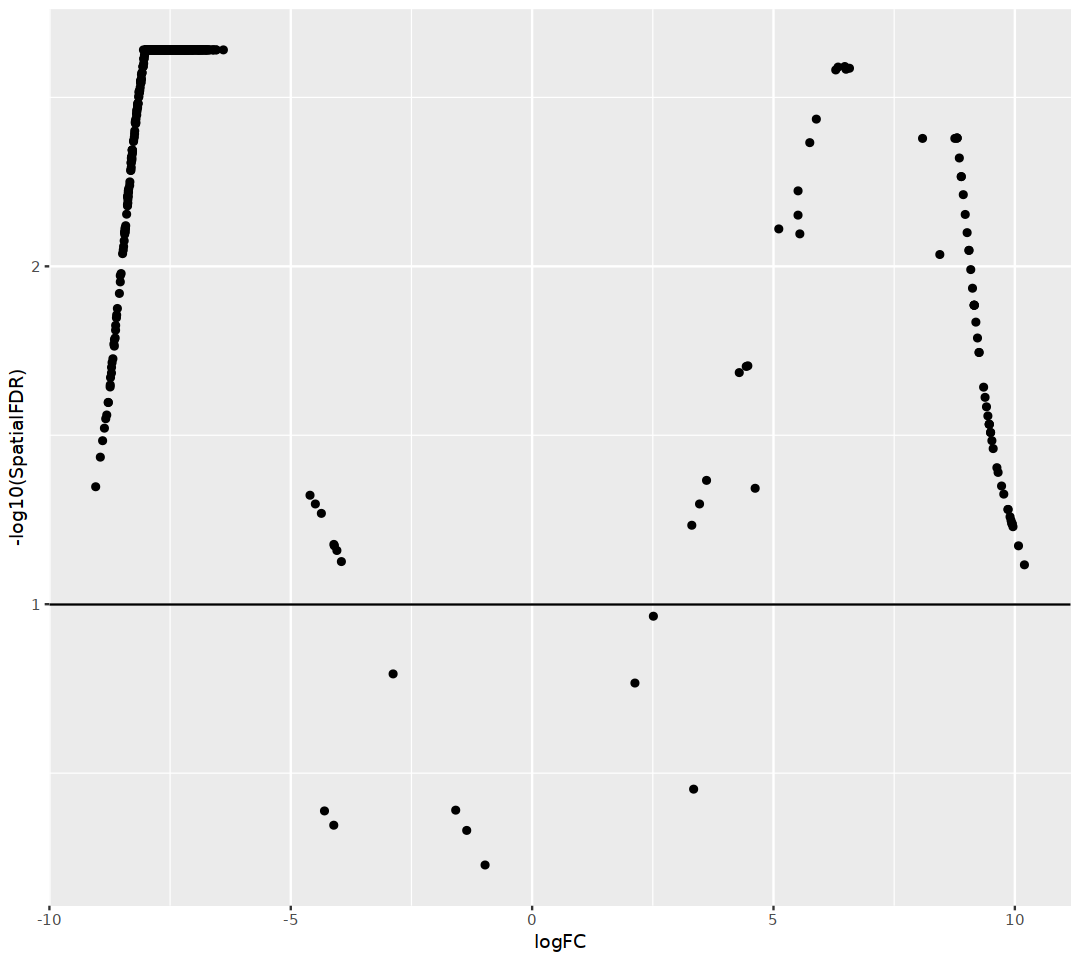

In [79]:
ggplot(results, aes(PValue)) + geom_histogram(bins=50)
ggplot(results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) 

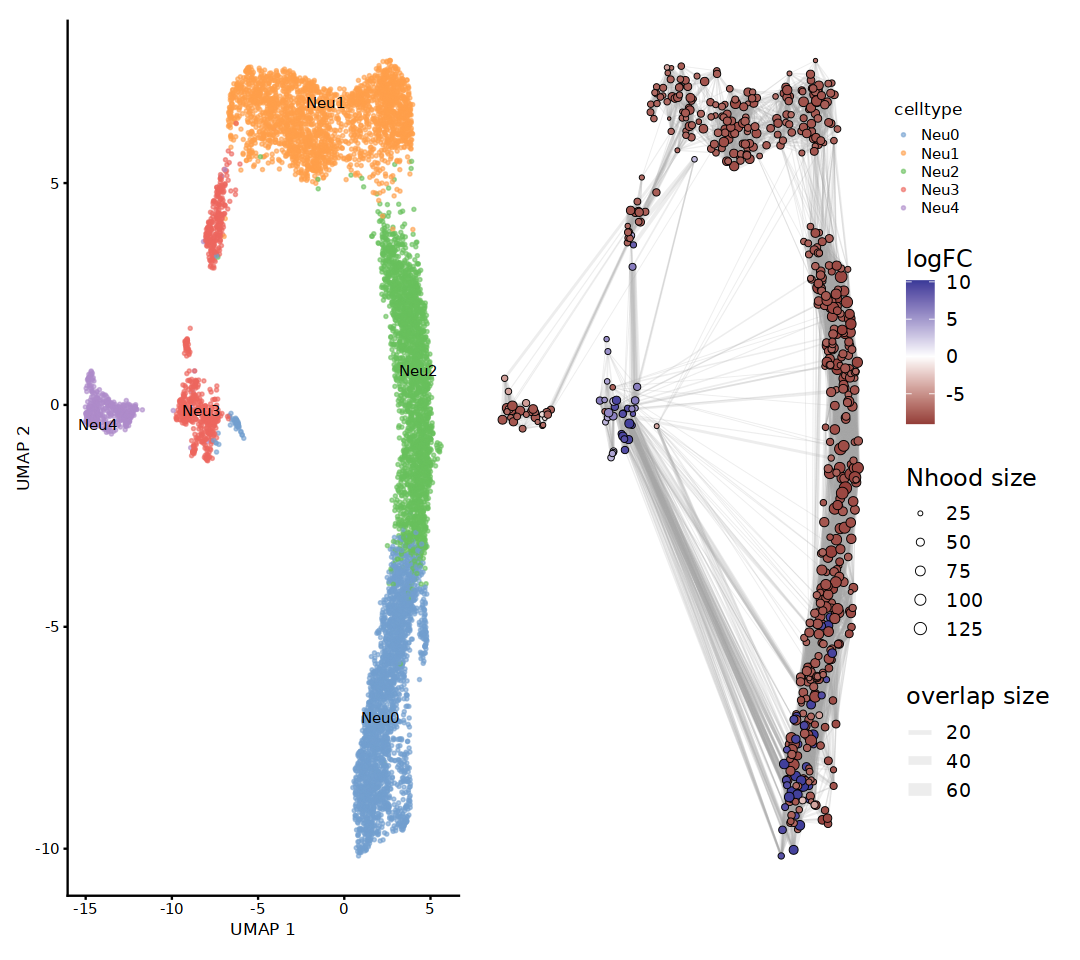

In [80]:
scmilo <- buildNhoodGraph(scmilo)
 
## Plot single-cell UMAP
umap_pl <- plotReducedDim(scmilo, dimred = "UMAP", 
                          colour_by="celltype", text_by = "celltype", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")
 
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(scmilo, results, layout="UMAP",alpha = 1) 
 
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [81]:
results <- annotateNhoods(scmilo, results, coldata_col = "celltype")

Converting celltype to factor...



In [82]:
table(results$celltype)


Neu0 Neu1 Neu2 Neu3 Neu4 
 177  173  157   51   30 

In [83]:
# https://rdrr.io/github/MarioniLab/miloR/f/vignettes/milo_contrasts.Rmd

Converting group.by to factor...



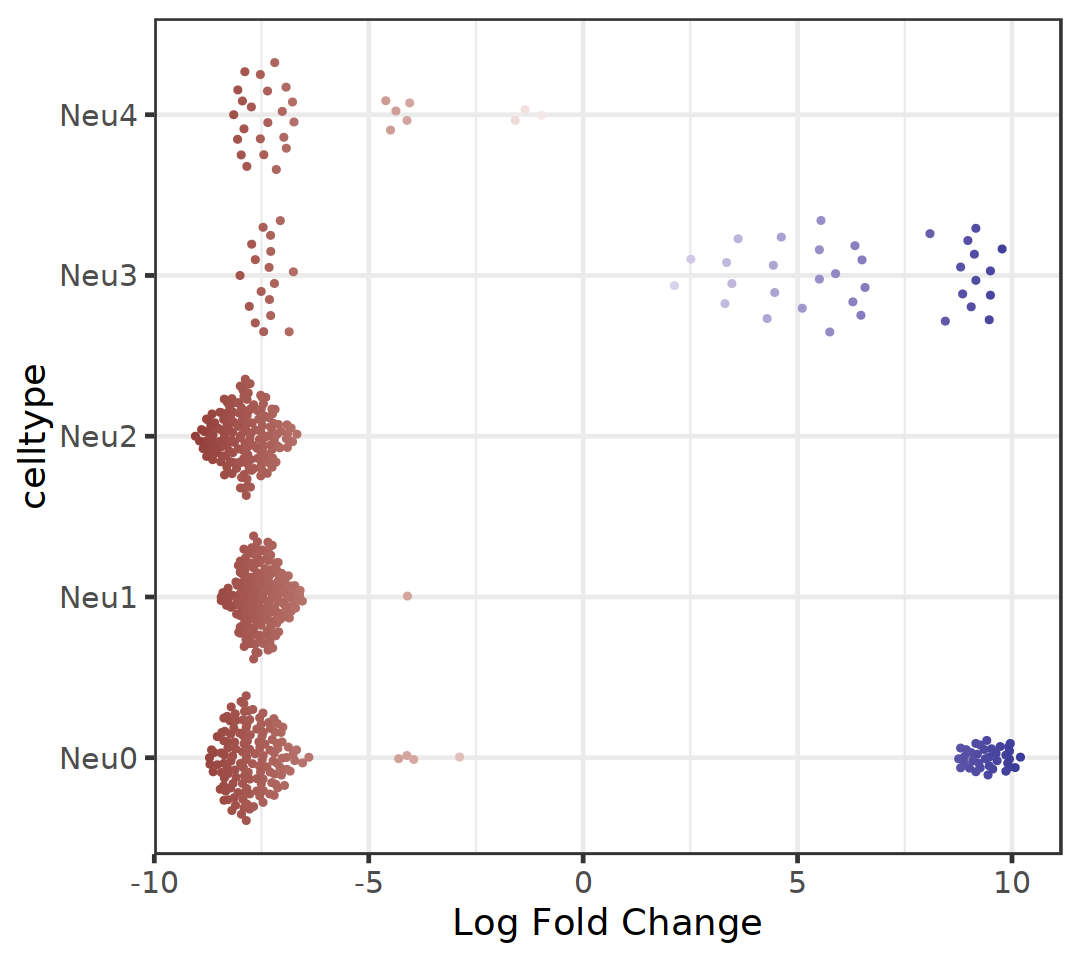

In [84]:
plotDAbeeswarm(results, group.by = "celltype",alpha = 1)